In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re

In [2]:
GAMMAS = ['1.0','0.9','0.8','0.7','0.6','0.5']
INDEX_TIME_UNIT = 1000 # number of tweets
QUERY_TIME_UNIT = 1000 # number of tweets
SIMILARITY_THRE = 0.5
NUMBER_OF_RUNS = 3
OUTPUT_DIR = "./output_expm1/n9/"

def get_chance(gamma):
    if gamma == '1.0':
        return '100'
    elif gamma == '0.9':
        return '90'
    elif gamma == '0.8':
        return '80'
    elif gamma == '0.7':
        return '70'
    elif gamma == '0.6':
        return '60'
    elif gamma == '0.5':
        return '50'
    
def get_gamma_index(gamma):
    if gamma == '1.0':
        return 0
    elif gamma == '0.9':
        return 1
    elif gamma == '0.8':
        return 2
    elif gamma == '0.7':
        return 3
    elif gamma == '0.6':
        return 4
    elif gamma == '0.5':
        return 5
    
SUMMARY_INDEX = pd.Index(['Run', 'Chance', 'Index time unit', 'Query time unit', 'Similarity threshold', 
                 'Query counts', 'Indexed tweet counts', 'Index size'])
SUMMARY_COL = ['Summary_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_RESULT_COL = ['Result_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_SIMILARITY_COL = ['Similarity_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_LOOKUPS_COL = ['Lookups_' + get_chance(p) + '%' for p in GAMMAS]
INDEX_TIME_COL = ['Index_time_run{}_{}%'.format(str(i+1), get_chance(p)) for p in GAMMAS for i in range(NUMBER_OF_RUNS)]
QUERY_TIME_COL = ['Query_time_run{}_{}%'.format(str(i+1), get_chance(p)) for p in GAMMAS for i in range(NUMBER_OF_RUNS)]

FREQ_TABLES_X = ['Posting_list_length_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_RECALL_X = ['Query_recall_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_PRECISION_X = ['Query_precision_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_LESS_LOOKUPS_X = ['Query_of_less_lookups_' + get_chance(p) + '%' for p in GAMMAS]
AVERAGE_LOOKUPS_X = ['Average_lookup_counts_' + get_chance(p) + '%' for p in GAMMAS]
PLOT_X = [get_chance(p) + '%' for p in GAMMAS]

# Run Experiment  One and Read in Results

* Use single terms to construct index
* Each term has a 100% chance to 50% chance to be included in the index or fingerprint

In [3]:
def runSketchTweets(jar, index_time_unit, query_time_unit, chance_gamma, similarity_threshold, n, output_dir):
    for run in range (1, n+1):
        os.system("java -jar ./{}.jar -iu {} -qu {} -p {} -s {} -n {} -o {}"
        .format(jar, index_time_unit, query_time_unit, chance_gamma, similarity_threshold, run, output_dir))
#         print("java -jar ./{}.jar -iu {} -qu {} -p {} -s {} -n {} -o {}"
#         .format(jar, index_time_unit, query_time_unit, chance_gamma, similarity_threshold, run, output_dir))

In [4]:
# This function runs the experiment and compares the results including:
# - the size of the index and doc lists 
# - time for constructing the index and executing query 
# - number of lookups before finding the match

def run_expm1():
    for p in GAMMAS:
        runSketchTweets("SketchingTweet-v1_n9", INDEX_TIME_UNIT, QUERY_TIME_UNIT, p, SIMILARITY_THRE, NUMBER_OF_RUNS, OUTPUT_DIR)
    results = load_expm1_csv(OUTPUT_DIR)
    return results

In [5]:
def load_expm1_csv(directory):
    '''
    Returns a dictionary of results.
    The dictionary keys are: summary, termfreq, query_results_similarity_lookups, index_time, query_time
    '''
    results = {}
    summary = [0] * len(GAMMAS)
    termfreq = [0] * len(GAMMAS)
    query_result = [0] * len(GAMMAS)
    query_similarity = [0] * len(GAMMAS)
    query_lookups = [0] * len(GAMMAS)
    index_time = [[0 for j in range(NUMBER_OF_RUNS)] for i in range(len(GAMMAS))]
    query_time = [[0 for j in range(NUMBER_OF_RUNS)] for i in range(len(GAMMAS))]
      

    for root, _, files in os.walk(directory):
        for file in files:
            filename = re.match( r'Epoch_(\d+)_iu_(\d+)_qu_(\d+)_p_(\d+\.\d+)_s_([\.\d]+)_(.+).csv', file)  
#             print(filename.group(3),filename.group(4),filename.group(5),filename.group(6))
            name = filename.group(6)
            gamma = filename.group(4)

            if name == "summary":    
                for p in GAMMAS:
                    if gamma == p:
                        summary[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)

            if name == "term_freq":
                for p in GAMMAS:
                    if gamma == p:
                        termfreq[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_result":
                for p in GAMMAS:
                    if gamma == p:
                        query_result[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_similarity":
                for p in GAMMAS:
                    if gamma == p:
                        query_similarity[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "lookups":
                for p in GAMMAS:
                    if gamma == p:
                        query_lookups[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
            
            if name == "index_time":
                run = filename.group(1)
                for p in GAMMAS:
                    if gamma == p:
                        for i in range(0,NUMBER_OF_RUNS):
                            if run == str(i+1):
                                index_time[get_gamma_index(gamma)][i] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_time":
                run = filename.group(1)
                for p in GAMMAS:
                    if gamma == p:
                        for i in range(0,NUMBER_OF_RUNS):
                            if run == str(i+1):
                                query_time[get_gamma_index(gamma)][i] = pd.read_csv(directory + "/" + file, header=None)
                  
    
    summary = pd.concat(summary, 1)
    summary = summary.set_index(SUMMARY_INDEX)
    summary.columns = SUMMARY_COL
#     print(summary)
    
    for table in termfreq:
        termfreq_index = table.iloc[:,0]
        table.set_index(termfreq_index, inplace=True)
        table.drop(table.columns[0], axis=1, inplace=True)
        table.columns = ['number_of_terms', 'posting_count']
#     print(termfreq)
    
    query_result = pd.concat(query_result, 1)
    query_result.columns = QUERY_RESULT_COL
#     print(query_result)
    
    query_similarity = pd.concat(query_similarity, 1)
    query_similarity.columns = QUERY_SIMILARITY_COL
#     print(query_similarity)

    query_lookups = pd.concat(query_lookups, 1)
    query_lookups.columns = QUERY_LOOKUPS_COL
#     print(query_lookups)

    query_result_similarity_lookup = [query_result, query_similarity, query_lookups]
    query_result_similarity_lookup = pd.concat(query_result_similarity_lookup, 1)
#     print(query_result_similarity_lookup)
    
    index_time_dfs = []
    for p in index_time:
        index_time_df = pd.concat(p, 1)
        index_time_dfs.append(index_time_df)
    index_time = pd.concat(index_time_dfs, 1)
    index_time.columns = INDEX_TIME_COL
    
    query_time_dfs = []
    for p in query_time:
        query_time_df = pd.concat(p, 1)
        query_time_dfs.append(query_time_df)
    query_time = pd.concat(query_time_dfs, 1)
    query_time.columns = QUERY_TIME_COL
    
    results['summary'] = summary
    results['termfreq'] = termfreq
    results['query_result_similarity_lookup'] = query_result_similarity_lookup
    results['index_time'] = index_time
    results['query_time'] = query_time
  
    return results

In [6]:
results = run_expm1() 

# Process Results

In [7]:
def plot_linechart(title, x, y, x_label, y_label, scale='linear'):
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()
    
def plot_scatter(title, x, y, x_label, y_label, scale='linear'):
    plt.scatter(x, y, s=0.5)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()
    
def plot_barchart(title, x, y, x_label, y_label, color="#66B3BA"):
    layer = sns.barplot(x=x, y=y, color=color)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    
def plot_boxplot(title, data, y_label, scale='linear'):
    layer = sns.boxplot(data=data)
    layer = sns.stripplot(data=data, color="orange", jitter=0.2, size=1.5)
    plt.title(title)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()

## Index size comparison

In [8]:
summary = results['summary']
summary

,Summary_100%,Summary_90%,Summary_80%,Summary_70%,Summary_60%,Summary_50%
Run,1,1,1,1,1,1
Chance,100.0%,90.0%,80.0%,70.0%,60.0%,50.0%
Index time unit,1000,1000,1000,1000,1000,1000
Query time unit,1000,1000,1000,1000,1000,1000
Similarity threshold,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Query counts,21890,21890,21890,21890,21890,21890
Indexed tweet counts,197610,197610,197610,197610,197610,197610
Index size,215201,187184,169257,149989,129512,108636


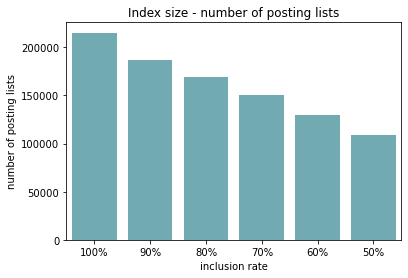

Summary_100%    215201
Summary_90%     187184
Summary_80%     169257
Summary_70%     149989
Summary_60%     129512
Summary_50%     108636
Name: Index size, dtype: object

In [9]:
# index size - number of posting lists
def compare_index_size(sizes, title):
    data = pd.to_numeric(sizes).to_list()
    plot_barchart(title, PLOT_X, data, 'inclusion rate', 'number of posting lists')

compare_index_size(summary.loc['Index size'], "Index size - number of posting lists")
summary.loc['Index size']

## Documnet list length comparison

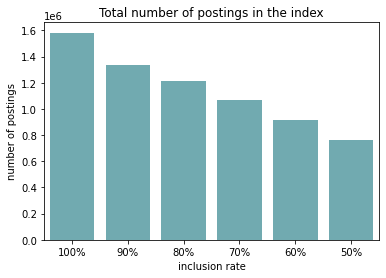

Total number of postings:


[1582263, 1333739, 1211613, 1070232, 919029, 766235]

In [10]:
freq_tables = results['termfreq']
posting_list_length_distribution = [table['posting_count'].value_counts().sort_index(inplace=False) for table in freq_tables]
total_posting_counts = [sum(table['posting_count']) for table in freq_tables]
plot_barchart('Total number of postings in the index', PLOT_X, total_posting_counts, 'inclusion rate', 'number of postings')
print('Total number of postings:')
total_posting_counts

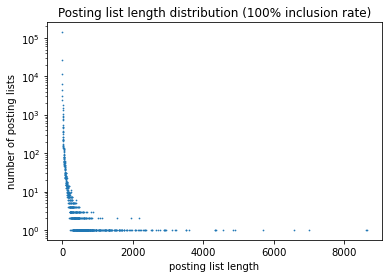

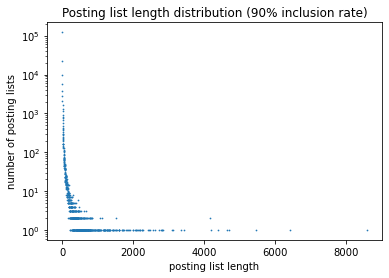

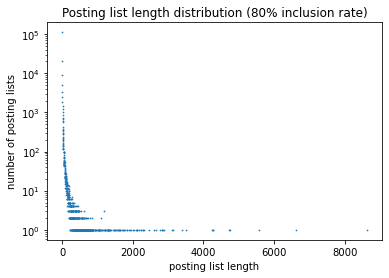

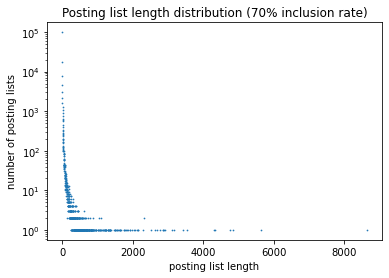

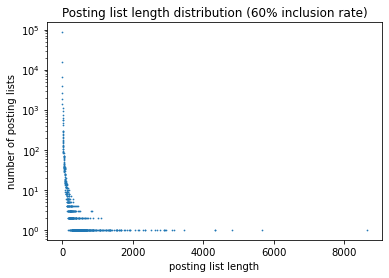

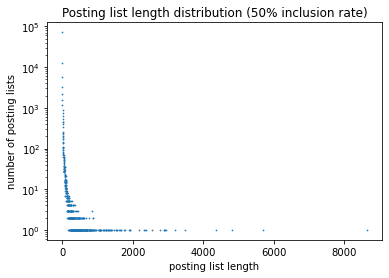

In [11]:
def compare_postinglist_length_distribution(PLOT_X, posting_list_length_distribution):
    for i in range(len(PLOT_X)):
        title = f'Posting list length distribution ({PLOT_X[i]} inclusion rate)'
        x = posting_list_length_distribution[i].index
        y = posting_list_length_distribution[i]
        plot_scatter(title, x, y, 'posting list length', 'number of posting lists', scale='log')   
compare_postinglist_length_distribution(PLOT_X, posting_list_length_distribution)

Average posting list length
[7.352489068359348, 7.125283143858449, 7.158421808256084, 7.135403262905946, 7.096091481870406, 7.053232814168416]


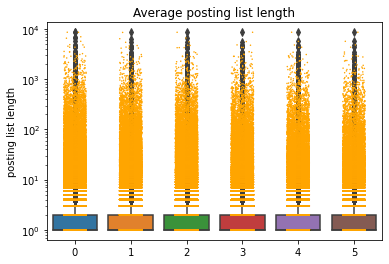

In [12]:
def compare_posting_list_len(PLOT_X, freq_tables):
    lengths = [table['posting_count'] for table in freq_tables]
    avgs = [sum(l)/len(l) for l in lengths]
    print("Average posting list length")
    print(avgs)
#     index15 = [int(round(len(l)*0.15,0)) for l in lengths]
#     index85 = [int(round(len(l)*0.85,0)) for l in lengths]
#     nooutlier_lengths = [ lengths[i][index15[i]:index85[i]] for i in range(len(lengths))]
    plot_boxplot(f'Average posting list length', lengths, 'posting list length', scale='log')
    
compare_posting_list_len(PLOT_X, freq_tables)

## Query Recall

In [13]:
query_result_similarity_lookup = results['query_result_similarity_lookup']
query_result_similarity_lookup

,Result_100%,Result_90%,Result_80%,Result_70%,Result_60%,Result_50%,Similarity_100%,Similarity_90%,Similarity_80%,Similarity_70%,Similarity_60%,Similarity_50%,Lookups_100%,Lookups_90%,Lookups_80%,Lookups_70%,Lookups_60%,Lookups_50%
0,189567,189567,189567,189567,189567,189567,0.63636,0.55556,0.55556,0.75000,0.66667,0.60000,5137,3555,3627,3392,1440,640
1,146028,146028,146028,146028,197559,191639,0.50000,0.50000,0.50000,0.66667,0.50000,1.00000,6516,4164,4264,3216,2,1
2,-1,-1,-1,145908,145908,145908,0.00000,0.00000,0.00000,0.50000,0.60000,0.50000,-1,-1,-1,1572,1310,184
3,-1,-1,-1,-1,-1,185838,0.00000,0.00000,0.00000,0.00000,0.00000,0.50000,-1,-1,-1,-1,-1,2
4,-1,-1,-1,-1,-1,157608,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,-1,-1,-1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21885,-1,-1,-1,-1,196841,196841,0.00000,0.00000,0.00000,0.00000,0.50000,0.50000,-1,-1,-1,-1,2,2
21886,-1,-1,-1,-1,-1,-1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-1,-1,-1,-1,-1,-1
21887,-1,-1,-1,-1,-1,197608,0.00000,0.00000,0.00000,0.00000,0.00000,0.50000,-1,-1,-1,-1,-1,2
21888,-1,-1,-1,-1,-1,195394,0.00000,0.00000,0.00000,0.00000,0.00000,0.50000,-1,-1,-1,-1,-1,324


In [14]:
has_true_similar = query_result_similarity_lookup[QUERY_RESULT_COL[0]] != -1
true_similar = query_result_similarity_lookup[has_true_similar]
num_true_similar = true_similar.shape[0]
true_similar

,Result_100%,Result_90%,Result_80%,Result_70%,Result_60%,Result_50%,Similarity_100%,Similarity_90%,Similarity_80%,Similarity_70%,Similarity_60%,Similarity_50%,Lookups_100%,Lookups_90%,Lookups_80%,Lookups_70%,Lookups_60%,Lookups_50%
0,189567,189567,189567,189567,189567,189567,0.63636,0.55556,0.55556,0.75000,0.66667,0.60000,5137,3555,3627,3392,1440,640
1,146028,146028,146028,146028,197559,191639,0.50000,0.50000,0.50000,0.66667,0.50000,1.00000,6516,4164,4264,3216,2,1
8,44802,44802,197071,197071,197071,197071,0.60000,0.60000,0.50000,0.50000,0.50000,0.66667,38975,37630,60,60,60,42
12,170152,193999,193999,197505,197505,197505,0.60000,0.50000,0.50000,0.50000,0.50000,0.50000,7605,352,360,2,2,2
15,102434,102434,168323,187662,187662,187662,0.50000,0.50000,0.50000,0.66667,0.66667,0.66667,10200,9762,864,219,219,219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21878,197554,197554,197554,197554,197554,197554,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,7,7,6,6,5,4
21880,197554,197554,197554,197554,197554,197554,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,7,7,6,6,5,4
21881,93654,-1,-1,-1,93654,93654,0.53846,0.00000,0.00000,0.00000,0.55556,0.55556,81484,-1,-1,-1,49878,50796
21884,178680,178680,178680,178680,178680,178680,0.62500,0.71429,0.71429,0.66667,0.66667,0.66667,120,84,84,66,66,66


In [15]:
num_correct_searches = []
correct_searches = []
for i in range(len(QUERY_RESULT_COL)):
    is_correct_search = true_similar[QUERY_RESULT_COL[0]] == true_similar[QUERY_RESULT_COL[i]]
    correct_search = true_similar[is_correct_search]
    correct_searches.append(correct_search)
    num_correct_searches.append(correct_search.shape[0])
print('Number of true similar tweets that we found: ')
num_correct_searches

Number of true similar tweets that we found: 


[7247, 5036, 4330, 3695, 2963, 2226]

Using 100% of terms, we can find 100.0% truly similar tweets
Using 90% of terms, we can find 69.49% truly similar tweets
Using 80% of terms, we can find 59.75% truly similar tweets
Using 70% of terms, we can find 50.99% truly similar tweets
Using 60% of terms, we can find 40.89% truly similar tweets
Using 50% of terms, we can find 30.72% truly similar tweets


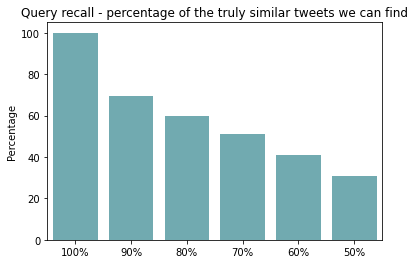

In [16]:
def compare_query_recall(recalls, title): 
    layer = sns.barplot(x=PLOT_X, y=recalls, color="#66B3BA")
    plt.title(title)
    layer.set(ylabel='Percentage')
    plt.show()

recalls = []
true_searches = []
for i in range(len(num_correct_searches)):
    true_searches.append(num_correct_searches[i])
    recall = round((num_correct_searches[i]/num_true_similar) * 100, 2)
    recalls.append(recall)
    chance = PLOT_X[i]
    print('Using {} of terms, we can find {}% truly similar tweets'.format(chance, recall))
    
compare_query_recall(recalls, 'Query recall - percentage of the truly similar tweets we can find')

## Query Precision

In [17]:
# is_predict_similar = query_result_similarity_lookup['Result_75%'] != -1
# predict_similar = query_result_similarity_lookup[is_predict_similar]
# num_predict_similar = predict_similar.shape[0]
# predict_similar
num_predict_similar_lst = []
predict_similar_lst = []
for i in range(len(QUERY_RESULT_COL)):
    is_predict_similar = query_result_similarity_lookup[QUERY_RESULT_COL[i]] != -1
    predict_similar = query_result_similarity_lookup[is_predict_similar]
    predict_similar_lst.append(predict_similar)
    num_predict_similar_lst.append(predict_similar.shape[0])
print("The number of tweets that we think are similar: ")
num_predict_similar_lst

The number of tweets that we think are similar: 


[7247, 8057, 9275, 10723, 12461, 13996]

Using 100% of terms, 100.0% tweets that we found similar are truly similar tweets
Using 90% of terms, 62.5% tweets that we found similar are truly similar tweets
Using 80% of terms, 46.68% tweets that we found similar are truly similar tweets
Using 70% of terms, 34.46% tweets that we found similar are truly similar tweets
Using 60% of terms, 23.78% tweets that we found similar are truly similar tweets
Using 50% of terms, 15.9% tweets that we found similar are truly similar tweets


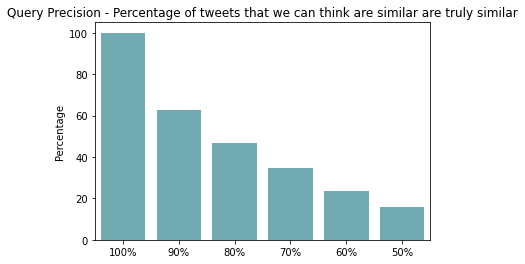

In [18]:
def compare_query_precision(precisions, title): 
    layer = sns.barplot(x=PLOT_X, y=precisions, color="#66B3BA")
    layer.set(ylabel='Percentage')
    plt.title(title)
    plt.show()

precisions = []
for i in range(len(num_predict_similar_lst)):
    precision = round((num_correct_searches[i]/num_predict_similar_lst[i]) * 100, 2)
    precisions.append(precision)
    chance = PLOT_X[i]
    print('Using {} of terms, {}% tweets that we found similar are truly similar tweets'.format(chance, precision))
    
compare_query_precision(precisions, 'Query Precision - Percentage of tweets that we can think are similar are truly similar')

## Number of searches that need fewer lookups

In [19]:
correct_search

,Result_100%,Result_90%,Result_80%,Result_70%,Result_60%,Result_50%,Similarity_100%,Similarity_90%,Similarity_80%,Similarity_70%,Similarity_60%,Similarity_50%,Lookups_100%,Lookups_90%,Lookups_80%,Lookups_70%,Lookups_60%,Lookups_50%
0,189567,189567,189567,189567,189567,189567,0.63636,0.55556,0.55556,0.75000,0.66667,0.60000,5137,3555,3627,3392,1440,640
18,196085,196085,196085,197415,197415,196085,0.80000,0.80000,0.80000,0.50000,0.50000,0.66667,255,250,250,12,12,117
45,196644,196644,196644,196644,196644,196644,0.80000,0.66667,0.50000,0.50000,0.50000,0.50000,35,21,2,2,2,2
55,196844,196844,196844,196844,196844,196844,0.85714,0.55556,0.55556,0.77778,0.77778,0.71429,224,117,135,126,135,105
73,34300,34300,34300,34300,34300,34300,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,30897,20072,20520,20872,14336,14371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21878,197554,197554,197554,197554,197554,197554,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,7,7,6,6,5,4
21880,197554,197554,197554,197554,197554,197554,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,7,7,6,6,5,4
21881,93654,-1,-1,-1,93654,93654,0.53846,0.00000,0.00000,0.00000,0.55556,0.55556,81484,-1,-1,-1,49878,50796
21884,178680,178680,178680,178680,178680,178680,0.62500,0.71429,0.71429,0.66667,0.66667,0.66667,120,84,84,66,66,66


In [20]:
query_of_less_lookups = []
less_search_lst = []
for i in range(len(QUERY_LOOKUPS_COL)):
    if i != 0:
        is_less_search = correct_searches[i][QUERY_LOOKUPS_COL[0]] > correct_searches[i][QUERY_LOOKUPS_COL[i]]
        less_search = correct_searches[i][is_less_search]
        less_search_lst.append(less_search)
        query_of_less_lookups.append(less_search.shape[0])
    else:
        less_search_lst.append(None)
        query_of_less_lookups.append(0)
print("The number of tweets that need less lookups before correctly finding the true similar tweets: ")
query_of_less_lookups

The number of tweets that need less lookups before correctly finding the true similar tweets: 


[0, 4882, 4247, 3624, 2904, 2199]

Using 100% of terms, 0.0% queries need less lookups before correctly finding the true similar tweets
Using 90% of terms, 96.94% queries need less lookups before correctly finding the true similar tweets
Using 80% of terms, 98.08% queries need less lookups before correctly finding the true similar tweets
Using 70% of terms, 98.08% queries need less lookups before correctly finding the true similar tweets
Using 60% of terms, 98.01% queries need less lookups before correctly finding the true similar tweets
Using 50% of terms, 98.79% queries need less lookups before correctly finding the true similar tweets


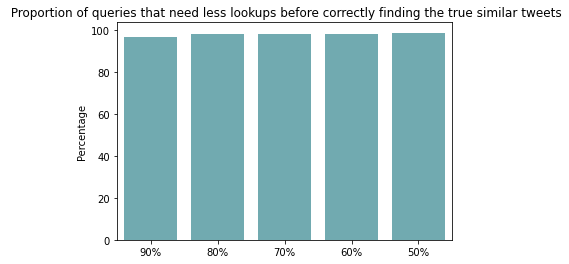

In [21]:
def compare_number_of_tweets_need_less_lookups(reduces, title): 
    layer = sns.barplot(x=PLOT_X[1:], y=reduces, color="#66B3BA")
    layer.set(ylabel='Percentage')
    plt.title(title)
    plt.show()

proportions = []
for i in range(len(query_of_less_lookups)):
    proportion = round((query_of_less_lookups[i] / num_correct_searches[i]) * 100, 2)
    proportions.append(proportion)
    chance = PLOT_X[i]
    print('Using {} of terms, {}% queries need less lookups before correctly finding the true similar tweets'.format(chance, proportion))
    
compare_number_of_tweets_need_less_lookups(proportions[1:], ' Proportion of queries that need less lookups before correctly finding the true similar tweets')

## Number of average lookups

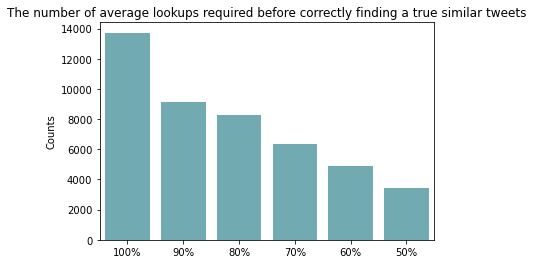

In [22]:
def compare_number_of_avg_lookups(reduces, title): 
    layer = sns.barplot(x=PLOT_X, y=reduces, color="#66B3BA")
    layer.set(ylabel='Counts')
    plt.title(title)
    plt.show()

avg_lookups = []
for i in range(len(QUERY_LOOKUPS_COL)):
    avg_lookup = np.average(np.array(correct_searches[i][QUERY_LOOKUPS_COL[i]]))
    avg_lookups.append(avg_lookup)

compare_number_of_avg_lookups(avg_lookups, 'The number of average lookups required before correctly finding a true similar tweets')

In [23]:
reduces = []
print('Comparing to using all the terms:')
for i in range(len(avg_lookups)):
    if i != 0:
        reduce = round(((avg_lookups[0] - avg_lookups[i]) / avg_lookups[0]) * 100, 2)
        reduces.append(reduce)
        chance = PLOT_X[i]
        print('By using {} of terms, {}% of less lookups are needed for correctly finding a true similar tweets'.format(chance, reduce))

Comparing to using all the terms:
By using 90% of terms, 33.26% of less lookups are needed for correctly finding a true similar tweets
By using 80% of terms, 39.95% of less lookups are needed for correctly finding a true similar tweets
By using 70% of terms, 53.69% of less lookups are needed for correctly finding a true similar tweets
By using 60% of terms, 64.54% of less lookups are needed for correctly finding a true similar tweets
By using 50% of terms, 74.76% of less lookups are needed for correctly finding a true similar tweets


## Index time comparison

In [24]:
index_time = results['index_time']
index_time

,Index_time_run1_100%,Index_time_run2_100%,Index_time_run3_100%,Index_time_run1_90%,Index_time_run2_90%,Index_time_run3_90%,Index_time_run1_80%,Index_time_run2_80%,Index_time_run3_80%,Index_time_run1_70%,Index_time_run2_70%,Index_time_run3_70%,Index_time_run1_60%,Index_time_run2_60%,Index_time_run3_60%,Index_time_run1_50%,Index_time_run2_50%,Index_time_run3_50%
0,12.4632,15.4857,17.5955,17.7189,18.4083,18.0552,17.0800,21.2485,17.0907,17.3269,16.7360,17.0948,16.1433,23.7163,20.3006,15.1588,16.5309,14.3245
1,5.1714,7.1966,10.1868,7.3842,11.8004,6.9733,6.3754,9.0538,5.7900,7.1344,6.9758,6.5999,8.1923,7.6295,7.1846,5.9714,6.9167,5.5217
2,4.5479,6.8427,9.5644,7.2275,8.5451,6.0331,6.0827,8.7125,5.6345,6.0708,6.7129,7.8253,6.7584,8.0611,6.8180,6.3048,5.6781,5.6783
3,4.1034,5.7880,8.0496,6.5370,6.6399,6.1044,7.8195,8.4477,5.4495,6.7406,6.3797,5.2559,6.2764,5.4768,6.6285,5.6325,5.0800,4.9186
4,4.5047,6.4254,6.4233,6.4143,6.7109,5.9044,8.3705,7.2930,4.9582,6.2312,6.1382,5.9222,6.4526,5.3868,6.2522,5.5307,5.4354,4.9708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,2.7017,2.1189,2.8533,4.0171,3.0949,3.4109,4.0910,3.7323,4.3105,2.9486,2.7792,3.1286,3.2868,3.4399,2.7264,2.8105,11.3918,3.3928
193,2.5455,2.0943,3.1411,4.0570,3.1055,3.2945,3.3623,3.9086,4.1503,2.9030,3.4256,3.3085,3.1772,3.3839,2.6030,2.5028,2.8881,11.6925
194,2.5521,2.3997,19.0419,3.9049,3.1302,3.2821,3.2758,3.7733,3.5028,2.9707,2.8546,3.0868,3.3812,3.4452,2.6912,2.5033,2.7544,2.6828
195,2.4757,2.6726,2.8288,3.7029,3.1990,3.1761,3.1116,16.2565,16.2033,2.8802,2.7085,3.0899,3.2121,3.6993,2.6108,2.4212,2.6953,2.5367


By using 100% of terms, the average time for indexing 1000 tweets is 3.4227 milliseconds
By using 90% of terms, the average time for indexing 1000 tweets is 4.1625 milliseconds
By using 80% of terms, the average time for indexing 1000 tweets is 4.0381 milliseconds
By using 70% of terms, the average time for indexing 1000 tweets is 4.1326 milliseconds
By using 60% of terms, the average time for indexing 1000 tweets is 3.7123 milliseconds
By using 50% of terms, the average time for indexing 1000 tweets is 3.638 milliseconds


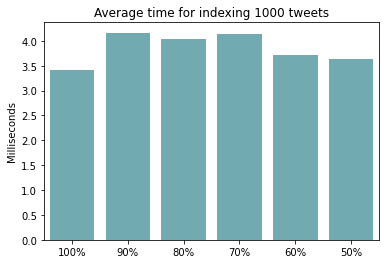

In [25]:
def compare_time(avg_time, title): 
    layer = sns.barplot(x=PLOT_X, y=avg_time, color="#66B3BA")
    layer.set(ylabel='Milliseconds')
    plt.title(title)
    plt.show()

index_time_avgs = []
for col in index_time.columns:
    index_time_avgs.append(np.average(np.array(index_time[col])))

index_time_avgs2 = []
c = 0
acc = 0
for avg in index_time_avgs:
    if c < 2:
        acc += avg
        c += 1
        
    else:
        acc += avg
#         print(acc)
        index_time_avgs2.append(round(acc/3 , 4))
        acc = 0
        c = 0

for i in range(len(index_time_avgs2)):
    print('By using {} of terms, the average time for indexing {} tweets is {} milliseconds'.format(PLOT_X[i], INDEX_TIME_UNIT, index_time_avgs2[i]))
compare_time(index_time_avgs2, 'Average time for indexing {} tweets'.format(INDEX_TIME_UNIT))

## Query time comparison

In [26]:
query_time = results['query_time']
query_time

,Query_time_run1_100%,Query_time_run2_100%,Query_time_run3_100%,Query_time_run1_90%,Query_time_run2_90%,Query_time_run3_90%,Query_time_run1_80%,Query_time_run2_80%,Query_time_run3_80%,Query_time_run1_70%,Query_time_run2_70%,Query_time_run3_70%,Query_time_run1_60%,Query_time_run2_60%,Query_time_run3_60%,Query_time_run1_50%,Query_time_run2_50%,Query_time_run3_50%
0,2.0831,2.8703,2.6076,2.0571,2.3592,3.3779,2.4840,15.1122,13.8969,2.1856,2.1921,2.1657,1.6718,1.6962,2.8525,2.2258,2.3920,1.6719
1,277.2370,324.3849,484.1636,252.0692,275.4994,242.8024,212.2302,214.6773,195.8053,174.6352,183.6141,184.2639,194.9816,176.0807,158.4458,125.9052,142.6945,157.5450
2,184.1729,212.0734,266.9476,138.5871,142.1226,136.6056,106.5044,102.1360,100.9715,77.1783,81.9919,87.5454,81.9072,74.2267,59.1414,35.6789,34.2420,37.9044
3,192.5941,209.3011,245.6875,140.4067,163.0669,148.3931,118.5518,140.1022,148.4278,84.1627,100.8806,94.4217,54.2127,56.2375,64.2425,36.9833,38.1997,36.8158
4,196.6767,221.1193,215.7661,145.4853,178.5968,146.2871,112.2197,124.3388,111.8829,84.6159,93.8755,91.6825,50.1297,52.1660,58.5774,34.6977,35.7622,35.7674
5,188.7602,206.3754,194.0167,139.9052,152.9914,141.2440,109.8812,131.9346,105.7170,112.7395,96.7422,96.8771,51.8969,52.9944,60.8718,35.3706,36.7280,35.7020
6,191.1872,204.9822,225.3357,141.7436,160.0022,145.2877,103.8044,107.5168,107.0430,85.3069,79.2500,90.4272,50.2274,53.5625,60.4164,33.6797,34.8114,33.8020
7,198.0966,210.8377,206.1298,141.7574,159.3482,144.6988,105.1656,114.9175,108.2200,94.4846,85.4183,93.5617,61.1179,61.6280,67.9315,41.3519,42.7147,40.0727
8,188.5935,243.6166,210.9937,141.6037,155.4100,160.1974,108.0569,110.6526,109.2656,91.0509,97.9733,92.1117,54.3055,53.1748,58.7534,36.8529,36.6073,34.5279
9,182.1793,190.3200,228.8610,135.3271,139.7747,160.9263,100.7408,130.9581,102.2957,82.5229,88.5461,84.0862,50.2603,51.1609,56.5672,32.6346,33.9156,37.0294


By using 100% of terms, the average time for querying 1000 tweets is 195.4783 milliseconds
By using 90% of terms, the average time for querying 1000 tweets is 134.9449 milliseconds
By using 80% of terms, the average time for querying 1000 tweets is 105.0058 milliseconds
By using 70% of terms, the average time for querying 1000 tweets is 83.6463 milliseconds
By using 60% of terms, the average time for querying 1000 tweets is 57.3914 milliseconds
By using 50% of terms, the average time for querying 1000 tweets is 37.217 milliseconds


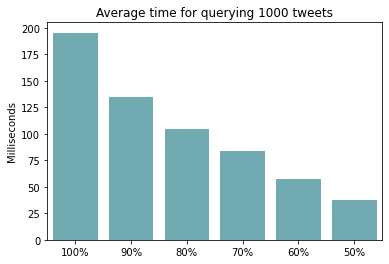

In [27]:
query_time_avgs = []
for col in query_time.columns:
    query_time_avgs.append(np.average(np.array(query_time[col])))

query_time_avgs2 = []
c = 0
acc = 0
for avg in query_time_avgs:
    if c < 2:
        acc += avg
        c += 1
        
    else:
        acc += avg
#         print(acc)
        query_time_avgs2.append(round(acc/3 , 4))
        acc = 0
        c = 0

for i in range(len(query_time_avgs2)):
    print('By using {} of terms, the average time for querying {} tweets is {} milliseconds'.format(PLOT_X[i], INDEX_TIME_UNIT, query_time_avgs2[i]))
compare_time(query_time_avgs2, 'Average time for querying {} tweets'.format(INDEX_TIME_UNIT))